In [ ]:
!pip install tensorflow tensorflow-gpu matplotlib tensorflow-datasets ipywidgets

In [ ]:
!pip list

In [ ]:
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import numpy as np

In [3]:
tf_ds = tfds.load("mnist",split='train')

Dl Completed...:   0%|          | 0/5 [00:00<?, ? file/s]

Dataset mnist downloaded and prepared to /root/tensorflow_datasets/mnist/3.0.1. Subsequent calls will reuse this data.


In [4]:
data = tf_ds.as_numpy_iterator()

In [5]:
data.next()['image'].shape

(28, 28, 1)

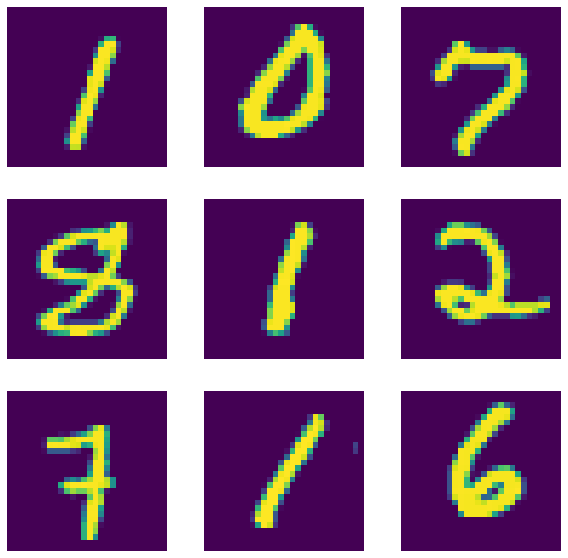

In [6]:
plt.figure(figsize=(10,10))
for i in range(9):
  batch  = data.next()
  plt.subplot(3,3,i+1)
  plt.imshow(np.squeeze(batch['image']))
  plt.axis('off')

Data Preprocessing

In [7]:
def scale_images(data):
  img = data['image']
  # scale_data =  tf.image.resize(img, [56, 56])
  return img/255

In [8]:
tf_ds = tfds.load("mnist",split='train')
tf_ds = tf_ds.map(scale_images)
tf_ds=  tf_ds.cache()
tf_ds =tf_ds.batch(128)
tf_ds=  tf_ds.shuffle(1000)
tf_ds=  tf_ds.prefetch(64)

In [9]:
data = tf_ds.as_numpy_iterator()

In [10]:
data.next()[0].shape

(28, 28, 1)

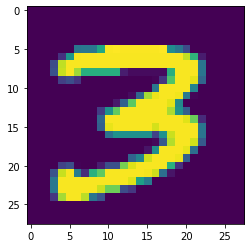

In [11]:
plt.imshow(np.squeeze(data.next()[0]))

In [12]:
from tensorflow.keras.layers import Dense,Conv2D,LeakyReLU,Dropout,UpSampling2D,Flatten,Reshape,MaxPooling2D

Build Generator

In [13]:
def Generator():
  model = tf.keras.Sequential([
      Dense(7*7*128, input_dim=128),
      LeakyReLU(0.2),
      Reshape((7,7,128)),

      UpSampling2D(),
      Conv2D(128,4,padding='same'),
      LeakyReLU(0.2),

      UpSampling2D(),
      Conv2D(128,4,padding='same'),
      LeakyReLU(0.2),

      Conv2D(128,4,padding='same'),
      LeakyReLU(0.2),

      Conv2D(128,4,padding='same'),
      LeakyReLU(0.2),
      
      Conv2D(1,4,padding='same',activation='sigmoid')

  ])
  return model

In [14]:
generator = Generator()
generator.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 6272)              809088    
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 6272)              0         
                                                                 
 reshape (Reshape)           (None, 7, 7, 128)         0         
                                                                 
 up_sampling2d (UpSampling2D  (None, 14, 14, 128)      0         
 )                                                               
                                                                 
 conv2d (Conv2D)             (None, 14, 14, 128)       262272    
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 14, 14, 128)       0         
                                                        

1/1 [==============================] - 8s 8s/step


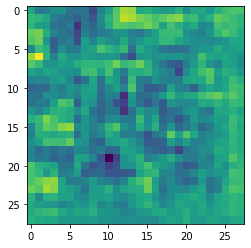

In [15]:
img = generator.predict(np.random.randn(4,128,1))
plt.imshow(np.squeeze(img[3]))

Build Discriminator

In [16]:

def Discriminator():
  model = tf.keras.Sequential([
      Conv2D(32,5,input_shape=(28,28,1)),
      LeakyReLU(0.2),
      Dropout(0.4),

      Conv2D(64,5),
      LeakyReLU(0.2),
      Dropout(0.4),

      Conv2D(128,5),
      LeakyReLU(0.2),
      Dropout(0.4),

      Conv2D(256,5),
      LeakyReLU(0.2),
      Dropout(0.4),

  
      Flatten(),
      Dropout(0.4),
      Dense(1,activation='sigmoid')

  ])
  return model

In [17]:
discriminator = Discriminator()
discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 24, 24, 32)        832       
                                                                 
 leaky_re_lu_5 (LeakyReLU)   (None, 24, 24, 32)        0         
                                                                 
 dropout (Dropout)           (None, 24, 24, 32)        0         
                                                                 
 conv2d_6 (Conv2D)           (None, 20, 20, 64)        51264     
                                                                 
 leaky_re_lu_6 (LeakyReLU)   (None, 20, 20, 64)        0         
                                                                 
 dropout_1 (Dropout)         (None, 20, 20, 64)        0         
                                                                 
 conv2d_7 (Conv2D)           (None, 16, 16, 128)      

In [18]:
img = generator.predict(np.random.randn(4,128,1))
img = img[0]
img.shape

1/1 [==============================] - 0s 24ms/step


(28, 28, 1)

In [19]:
discriminator.predict(np.expand_dims(img,0))

1/1 [==============================] - 0s 158ms/step


array([[0.499106]], dtype=float32)

Optimizer and losses

In [20]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy

In [21]:
g_opt = Adam(learning_rate=0.0001) 
d_opt = Adam(learning_rate=0.00001) 
g_loss = BinaryCrossentropy()
d_loss = BinaryCrossentropy()

Build Gans

In [22]:
from tensorflow.keras.models import Model

In [23]:
class GanModel(tf.keras.Model): 
    def __init__(self, generator, discriminator, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.generator = generator 
        self.discriminator = discriminator 
        
    def compile(self, g_opt, d_opt, g_loss, d_loss, *args, **kwargs): 
        super().compile(*args, **kwargs)
        self.g_opt = g_opt
        self.d_opt = d_opt
        self.g_loss = g_loss
        self.d_loss = d_loss 

    def train_step(self, batch):
        real_images = batch
        fake_images = self.generator(tf.random.normal((128, 128, 1)), training=False)
        
        # Train the discriminator
        with tf.GradientTape() as d_tape: 
            yhat_real = self.discriminator(real_images, training=True) 
            yhat_fake = self.discriminator(fake_images, training=True)
            yhat_realfake = tf.concat([yhat_real, yhat_fake], axis=0)

            y_realfake = tf.concat([tf.zeros_like(yhat_real), tf.ones_like(yhat_fake)], axis=0)

            noise_real = 0.15*tf.random.uniform(tf.shape(yhat_real))
            noise_fake = -0.15*tf.random.uniform(tf.shape(yhat_fake))
            y_realfake += tf.concat([noise_real, noise_fake], axis=0)
            
            # Calculate loss
            total_d_loss = self.d_loss(y_realfake, yhat_realfake)
            
        # Apply backpropagation
        dgrad = d_tape.gradient(total_d_loss, self.discriminator.trainable_variables) 
        self.d_opt.apply_gradients(zip(dgrad, self.discriminator.trainable_variables))
        
        # Train the generator 
        with tf.GradientTape() as g_tape: 
            gen_images = self.generator(tf.random.normal((128,128,1)), training=True)
            predicted_labels = self.discriminator(gen_images, training=False)
                                        
            # Calculate loss
            total_g_loss = self.g_loss(tf.zeros_like(predicted_labels), predicted_labels) 
            
        # Apply backprop
        ggrad = g_tape.gradient(total_g_loss, self.generator.trainable_variables)
        self.g_opt.apply_gradients(zip(ggrad, self.generator.trainable_variables))
        
        return {"d_loss":total_d_loss, "g_loss":total_g_loss}

In [24]:
ganmodel = GanModel(generator,discriminator)

In [25]:
ganmodel.compile(g_opt, d_opt, g_loss, d_loss)

Build CallBack

In [26]:
from tensorflow.keras.preprocessing.image import array_to_img
from tensorflow.keras.callbacks import Callback
import os

In [27]:
class ModelListen(Callback):
  def __init__(self,num_img=3,dim=128):
    self.num_img = num_img
    self.dim = dim
  def epoch_end(self,epoch,logs=None):
    random_val= tf.random.uniform((self.num_img,self.dim,1))
    generated_images = self.model.generator(random_val)
    generated_images *=255
    generated_images.numpy()
    for i in range(self.num_img):
      img = array_to_img(generated_images[i])
      img.save(os.path.join("/content/drive/MyDrive/Gans/gen_img",f'generated_img_{epoch}_{i}.png'))

Let's Train Model

In [28]:
history = ganmodel.fit(tf_ds,epochs=20,callbacks=[ModelListen()])

Epoch 1/20
469/469 [==============================] - 80s 161ms/step - d_loss: 0.4781 - g_loss: 1.7868
Epoch 2/20
469/469 [==============================] - 75s 160ms/step - d_loss: 0.2781 - g_loss: 2.5043
Epoch 3/20
469/469 [==============================] - 75s 160ms/step - d_loss: 0.4322 - g_loss: 1.9551
Epoch 4/20
469/469 [==============================] - 75s 161ms/step - d_loss: 0.7069 - g_loss: 0.6839
Epoch 5/20
469/469 [==============================] - 76s 161ms/step - d_loss: 0.6955 - g_loss: 0.6948
Epoch 6/20
469/469 [==============================] - 75s 161ms/step - d_loss: 0.6930 - g_loss: 0.7049
Epoch 7/20
469/469 [==============================] - 75s 161ms/step - d_loss: 0.6933 - g_loss: 0.7054
Epoch 8/20
469/469 [==============================] - 75s 161ms/step - d_loss: 0.6927 - g_loss: 0.7075
Epoch 9/20
469/469 [==============================] - 76s 161ms/step - d_loss: 0.6940 - g_loss: 0.7236
Epoch 10/20
469/469 [==============================] - 76s 161ms/step - d

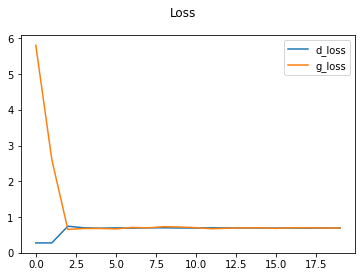

In [29]:
plt.suptitle('Loss')
plt.plot(history.history['d_loss'], label='d_loss')
plt.plot(history.history['g_loss'], label='g_loss')
plt.legend()
plt.show()

In [30]:
generator.save('/content/drive/MyDrive/Gans/generator.h5')
discriminator.save('/content/drive/MyDrive/Gans/discriminator.h5')

1/1 [==============================] - 0s 15ms/step


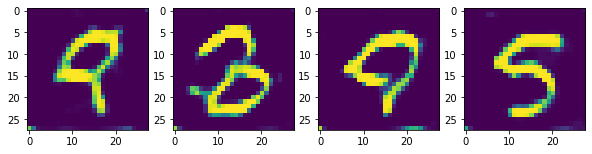

In [60]:
generator.load_weights('/content/drive/MyDrive/Gans/generator.h5')
imgs = generator.predict(tf.random.normal((4, 128, 1)))
plt.figure(figsize=(10,10))
for i in range(4):
  plt.subplot(1,4,i+1)
  plt.imshow(np.squeeze(imgs[i]))